# Affine registration with dipy

Dipy is a package for diffusion imaging, also written in Python.

It also has registration algorithms, including affine and non-linear registration.

These are based on the model and algorithms implemented in the ANTS toolbox : http://picsl.upenn.edu/software/ants/

Python is an excellent language to work in for this problem because Python code is easier for most scientists to read than C++ (ANTS is written in C++).  Dipy, like nipy, uses an optimized, compiled Python / C fusion language called Cython, that allows us to mix Python code and C-like code, and get the speed of compiled C code on execution.

This notebook is closely based on the 3D affine registration tutorial in the dipy documentation: http://nipy.org/dipy/examples_built/affine_registration_3d.html

In [1]:
# Set up our usual routines and configuration
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

Import the dipy routines we are going to need:

In [2]:
from dipy.viz import regtools
from dipy.align.imaffine import (AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

This time we will load the image with the `nibabel` library.  This is lower level than nipy.  Nipy depends on nibabel to load images under the hood:

In [3]:
import nibabel as nib

Again we make the mean functional image to register to:

In [4]:
func_img = nib.load('ds114_sub009_t2r1.nii')
mean_data = func_img.get_data()[..., 4:].mean(axis=-1)
mean_affine = func_img.affine

Next we load the structural image.  We will register this image to the mean functional.

In [5]:
source_img = nib.load('ds114_sub009_highres_brain.nii')

Dipy works on the image data arrays.   It also needs the affine arrays of each of the images:

In [6]:
source_data = source_img.get_data()
source_affine = source_img.affine
target_data = mean_data
target_affine = func_img.affine

Because the two images are already in good registration (see the nipy registration notebook), we disturb the registration by doing a 10mm shift to the left on the structural image.  This shift is just in the affine matrix, because the affine matrices record the current positions of the structural and functional image, relative to each other, and the world space of the scanner:

In [7]:
source_affine[0, -1] += 10

We use the nice dipy routines to show the spatial correspondence of the images, as recorded in the affines.

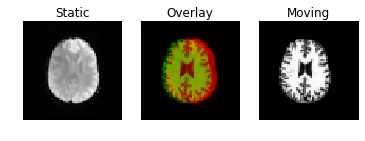

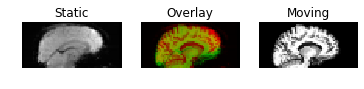

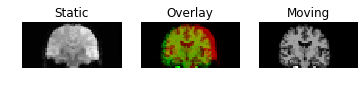

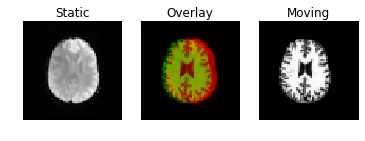

In [8]:
identity = np.eye(4)
affine_map = AffineMap(identity,
                       target_data.shape, target_affine,
                       source_data.shape, source_affine)
resampled = affine_map.transform(source_data)
regtools.overlay_slices(target_data, resampled, None, 0,
                        "Static", "Moving", "resampled_0.png")
regtools.overlay_slices(target_data, resampled, None, 1,
                        "Static", "Moving", "resampled_1.png")
regtools.overlay_slices(target_data, resampled, None, 2,
                        "Static", "Moving", "resampled_2.png")

Next we define an affine registration, by giving a few standard parameters.  See the dipy registration tutorial for the details of what these parameters mean:

In [9]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

In [10]:
level_iters = [10000, 1000, 100]

In [11]:
sigmas = [3.0, 1.0, 0.0]

In [12]:
factors = [4, 2, 1]

We set up the registration object, ready to do the registration:

In [13]:
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

First we optimize the translations.  We do the translations first to get these in the ballpark, by proceeding to do the translations and rotations at the same time:

In [14]:
transform = TranslationTransform3D()
params0 = None
translation = affreg.optimize(target_data, source_data, transform, params0,
                              target_affine, source_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


We now have our estimated translations.  Sure enough the x translation is about -10 mm, the amount we put in:

In [15]:
translation.affine

array([[  1.    ,   0.    ,   0.    ,  12.0894],
       [  0.    ,   1.    ,   0.    ,  -2.4918],
       [  0.    ,   0.    ,   1.    ,  -5.7955],
       [  0.    ,   0.    ,   0.    ,   1.    ]])

The visualization tool now shows the images overly much better than they did before:

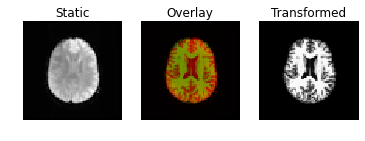

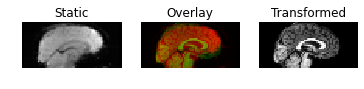

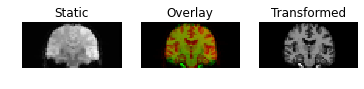

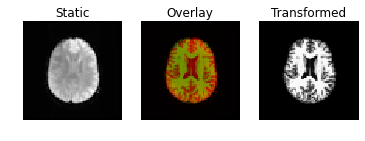

In [16]:
transformed = translation.transform(source_data)
regtools.overlay_slices(target_data, transformed, None, 0,
                        "Static", "Transformed", "transformed_trans_0.png")
regtools.overlay_slices(target_data, transformed, None, 1,
                        "Static", "Transformed", "transformed_trans_1.png")
regtools.overlay_slices(target_data, transformed, None, 2,
                        "Static", "Transformed", "transformed_trans_2.png")

Next we use the estimated translations as a starting point to optimize a rigid-body transform.  A rigid-body transform is a transform that does not change the shape of the object.  It allows only translations and rotations.

In [17]:
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine
rigid = affreg.optimize(target_data, source_data, transform, params0,
                        target_affine, source_affine,
                        starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [18]:
rigid.affine

array([[  0.9997,   0.018 ,   0.0145,  12.0093],
       [ -0.0178,   0.9997,  -0.0139,  -2.1073],
       [ -0.0147,   0.0136,   0.9998,  -8.046 ],
       [  0.    ,   0.    ,   0.    ,   1.    ]])

The estimated rotations are very small, so they don't make much difference to the overlay of the image.

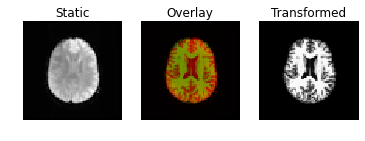

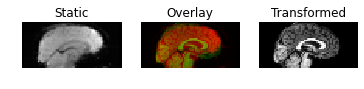

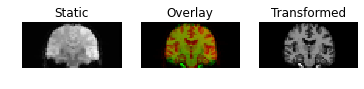

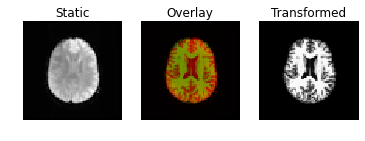

In [19]:
transformed = translation.transform(source_data)
regtools.overlay_slices(target_data, transformed, None, 0,
                        "Static", "Transformed", "transformed_trans_0.png")
regtools.overlay_slices(target_data, transformed, None, 1,
                        "Static", "Transformed", "transformed_trans_1.png")
regtools.overlay_slices(target_data, transformed, None, 2,
                        "Static", "Transformed", "transformed_trans_2.png")